In [1]:
# === Rice Leaf Disease Detection ===


import os, shutil, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# --- Config ---
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

BASE_DIR = Path(
    r"C:\Users\Vaibhav\Documents\Data science Class\projects internship\riceleaf-disease-detection\dataset"
)  # your dataset path

print("Python:", os.sys.version.splitlines()[0])
print("TensorFlow:", tf.__version__)


Python: 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]
TensorFlow: 2.20.0


In [2]:
# Supported image extensions
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}

TRAIN_DIR = BASE_DIR / "train"
TEST_DIR  = BASE_DIR / "test"

def has_class_subfolders(d: Path):
    return d.exists() and any((d / p).is_dir() for p in os.listdir(d))

if has_class_subfolders(TRAIN_DIR) and has_class_subfolders(TEST_DIR):
    print("Re-using existing train/test split.")
else:
    print("Creating new train/test split (80/20)...")
    TRAIN_DIR.mkdir(parents=True, exist_ok=True)
    TEST_DIR.mkdir(parents=True, exist_ok=True)

    # get class subfolders (ignore train/test)
    class_dirs = [p for p in BASE_DIR.iterdir() if p.is_dir() and p.name.lower() not in ("train","test")]
    for cls_dir in class_dirs:
        cls_name = cls_dir.name
        imgs = [p for p in cls_dir.iterdir() if p.suffix.lower() in IMAGE_EXTS]
        train_imgs, test_imgs = train_test_split(imgs, test_size=0.2, random_state=SEED)
        (TRAIN_DIR/cls_name).mkdir(parents=True, exist_ok=True)
        (TEST_DIR/cls_name).mkdir(parents=True, exist_ok=True)
        for p in train_imgs: shutil.copy2(p, TRAIN_DIR/cls_name/p.name)
        for p in test_imgs: shutil.copy2(p, TEST_DIR/cls_name/p.name)

print("Train folder:", TRAIN_DIR)
print("Test folder :", TEST_DIR)


Creating new train/test split (80/20)...
Train folder: C:\Users\Vaibhav\Documents\Data science Class\projects internship\riceleaf-disease-detection\dataset\train
Test folder : C:\Users\Vaibhav\Documents\Data science Class\projects internship\riceleaf-disease-detection\dataset\test


In [3]:
def count_images(folder: Path):
    counts = {}
    for cls in sorted([d for d in folder.iterdir() if d.is_dir()]):
        counts[cls.name] = len([p for p in cls.iterdir() if p.suffix.lower() in IMAGE_EXTS])
    return counts

print("Train counts:", count_images(TRAIN_DIR))
print("Test counts :", count_images(TEST_DIR))


Train counts: {'Bacterial leaf blight': 32, 'Brown spot': 32, 'Leaf smut': 31}
Test counts : {'Bacterial leaf blight': 8, 'Brown spot': 8, 'Leaf smut': 8}


In [4]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 8
EPOCHS = 20

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    str(TRAIN_DIR), target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical',
    shuffle=True, seed=SEED
)

test_gen = test_datagen.flow_from_directory(
    str(TEST_DIR), target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical',
    shuffle=False
)

class_labels = list(train_gen.class_indices.keys())
print("Class labels:", class_labels)


Found 95 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Class labels: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


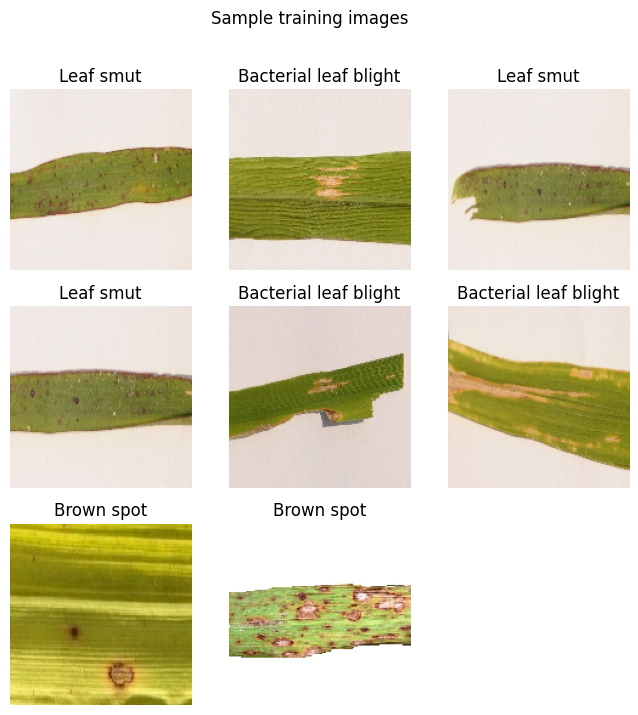

In [5]:
x_batch, y_batch = next(iter(train_gen))
plt.figure(figsize=(8,8))
for i in range(min(9, x_batch.shape[0])):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    plt.title(class_labels[int(np.argmax(y_batch[i]))])
    plt.axis("off")
plt.suptitle("Sample training images")
plt.show()


In [6]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(class_labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\Vaibhav\anaconda3\envs\riceleaf\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=test_gen,
    callbacks=cb,
    verbose=1
)


C:\Users\Vaibhav\anaconda3\envs\riceleaf\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - accuracy: 0.3158 - loss: 1.1276 - val_accuracy: 0.4167 - val_loss: 1.0868 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.4526 - loss: 1.0567 - val_accuracy: 0.5417 - val_loss: 0.9498 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.4842 - loss: 0.9594 - val_accuracy: 0.5417 - val_loss: 0.8303 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.5684 - loss: 0.8491 - val_accuracy: 0.5417 - val_loss: 1.1108 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.6316 - loss: 0.8386 - val_accuracy: 0.6667 - val_loss: 0.7433 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.6737 - loss: 0.7161 - val_accuracy: 0.7500 - val_loss: 0.6074 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.7474 - loss: 0.5699 - 

In [8]:
cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=test_gen,
    callbacks=cb,
    verbose=1
)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.9263 - loss: 0.2642 - val_accuracy: 0.7083 - val_loss: 0.5867 - learning_rate: 2.5000e-04
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.9053 - loss: 0.2453 - val_accuracy: 0.7500 - val_loss: 0.5290 - learning_rate: 2.5000e-04
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.9053 - loss: 0.2547 - val_accuracy: 0.7083 - val_loss: 0.5779 - learning_rate: 2.5000e-04
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.9158 - loss: 0.1858 - val_accuracy: 0.6667 - val_loss: 0.5504 - learning_rate: 2.5000e-04
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9434 - loss: 0.2025
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.9368 - loss: 0.1613 - val_accuracy: 0.7083 - val_loss: 0.5797 - learning_rate: 2.5000e-04
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.989

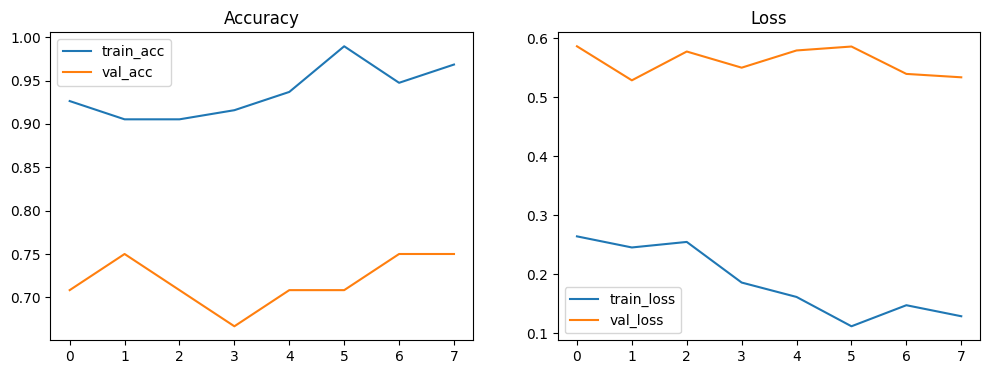

In [9]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.legend(); plt.title("Loss")

plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Classification report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.86      0.75      0.80         8
           Brown spot       0.62      0.62      0.62         8
            Leaf smut       0.78      0.88      0.82         8

             accuracy                           0.75        24
            macro avg       0.75      0.75      0.75        24
         weighted avg       0.75      0.75      0.75        24



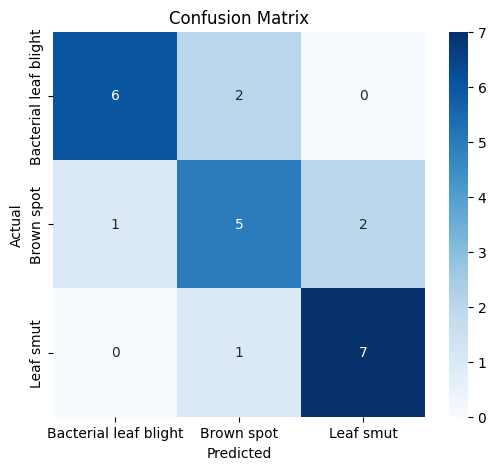

In [10]:
preds = model.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()


In [12]:
from pathlib import Path

# Create models folder
out_dir = Path.cwd() / "models"
out_dir.mkdir(exist_ok=True)

# Save in .keras format
save_path = out_dir / "rice_leaf_savedmodel.keras"
model.save(save_path)

print(" Model saved to:", save_path.resolve())


 Model saved to: C:\Users\Vaibhav\Documents\Data science Class\projects internship\riceleaf-disease-detection\models\rice_leaf_savedmodel.keras


In [15]:
def predict_image(path):
    img = Image.open(path).convert("RGB").resize(IMG_SIZE)
    x = np.array(img).astype('float32') / 255.0
    x = np.expand_dims(x, axis=0)
    p = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(p))
    return class_labels[idx], float(p[idx])

# Demo: predict on first test image
sample = next(TEST_DIR.rglob("*.*"), None)
if sample:
    lbl, conf = predict_image(sample)
    print("Example prediction:", lbl, f"(confidence {conf:.3f})")


Example prediction: Bacterial leaf blight (confidence 0.980)
